In [1]:
import argparse
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='gray')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
import os
from EyeTracking import EyeTrackingDataset
from Model2 import Net, parse_args
from mpl_toolkits.mplot3d import Axes3D

In [2]:
args = parse_args('--polar --validation-percentage 10 --batch-size 128 --epochs 8 --lr 0.1 --step 1 --gamma 0.7 --reg-lambda 0.001 --seed 1 --log-interval 20'.split())
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
path_outputs = '.'
model = Net(args).to(device)

In [3]:
dir_images = r'D:\Data\Unity\Minos\imagesFix2'
path_pos = r'D:\Data\Unity\Minos\posFix2.bin'
dataset = EyeTrackingDataset(path_pos, dir_images, polar=args.polar, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(60),
    transforms.ToTensor()
]))
test_loader = DataLoader(dataset, batch_size=args.batch_size, **kwargs)

In [4]:
model.load_state_dict(torch.load(os.path.join(path_outputs, 'model2_polar_1.pt')))

<All keys matched successfully>

In [27]:
def polar2cart(polar):
    '''
    Covert polar coords to left-hand cartesian coords
    polar is in [azimuth, elevation, distance]
    cart is in [x, y, z]
    '''
    cart = polar.copy()
    polar_tan = np.tan(np.deg2rad(polar))
    back = (np.logical_or(polar[:, 0]>-90, polar[:, 0]<90)-0.5)*2
    cart[:, 2] = polar[:, 2]/np.sqrt(1+polar_tan[:, 0]**2+polar_tan[:, 1]**2)*back
    cart[:, 0] = cart[:, 2]*polar_tan[:, 0]
    cart[:, 1] = cart[:, 2]*polar_tan[:, 1]
    return cart

In [6]:
def evaluate(model, device, data_loader, weight):
    model.eval()    # Set the model to inference mode
    target = None
    output = None
    ref = None
    with torch.no_grad():   # For the inference step, gradient is not computed
        for batch_idx, (data, gt, rt) in enumerate(data_loader):
            data = data.to(device)
            pred = model.forward(data, weight=weight)
            if (batch_idx+1) % args.log_interval == 0:
                print(f'Test batch {batch_idx+1}/{len(data_loader)}')
            if target is None:
                target = gt.numpy()
            else:
                target = np.vstack((target, gt.numpy()))
            if ref is None:
                ref = rt.numpy()
            else:
                ref = np.vstack((ref, rt.numpy()))
            if output is None:
                output = pred.cpu().numpy()
            else:
                output = np.vstack((output, pred.cpu().numpy()))
    return output, target, ref

In [7]:
weight = torch.tensor([1., 1., 0.5, 0.], device=device, pin_memory=True).reshape((1, 4))

output, target, ref = evaluate(model, device, test_loader, weight)

Test batch 20/250
Test batch 40/250
Test batch 60/250
Test batch 80/250
Test batch 100/250
Test batch 120/250
Test batch 140/250
Test batch 160/250
Test batch 180/250
Test batch 200/250
Test batch 220/250
Test batch 240/250


In [8]:
print(output.shape, target.shape, ref.shape)

(32000, 4) (32000, 4) (32000, 4)


In [9]:
error = np.abs(output-target)
error_fove = np.abs(ref-target)

In [10]:
dist_v = np.linspace(0.4, 10., 20)
dist = np.linspace(0.4, 10., 20).reshape((-1, 1)).repeat(1600, axis=1).flatten()
idc_dist = np.linspace(0, 19, 20).astype(np.int).reshape((-1, 1)).repeat(1600, axis=1).flatten()
dist_val = dist
idc_val = idc_dist

In [11]:
error_m = np.zeros((20, 4))
error_fove_m = np.zeros((20, 4))
error_std = np.zeros((20, 4))
error_fove_std = np.zeros((20, 4))
for k in range(20):
    error_m[k, :] = error[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].mean(axis=0)
    error_fove_m[k, :] = error_fove[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].mean(axis=0)
    error_std[k, :] = error[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].std(axis=0)/np.sqrt((idc_val==k).sum())
    error_fove_std[k, :] = error_fove[np.ix_(idc_val==k, np.ones(4, dtype=np.bool))].std(axis=0)/np.sqrt((idc_val==k).sum())


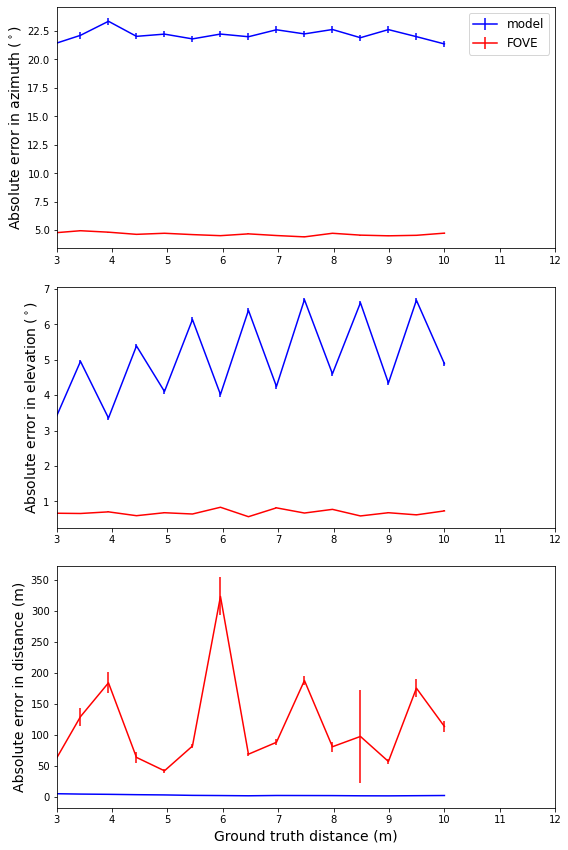

In [11]:
fig = plt.figure(figsize=(8, 12), tight_layout=True)
ylabels = ['Absolute error in azimuth ($^\circ$)', 'Absolute error in elevation ($^\circ$)', 'Absolute error in distance (m)']
for k in range(3):
    plt.subplot(3, 1, k+1)
    plt.errorbar(dist_v, error_m[:, k], fmt='b', yerr=error_std[:, k], label='model')
    plt.errorbar(dist_v, error_fove_m[:, k], fmt='r', yerr=error_fove_std[:, k], label='FOVE')
    plt.xlim(3, 12)
    plt.ylabel(ylabels[k], fontsize=14)
    if k==0:
        plt.legend(fontsize=12)
    if k==2:
        plt.xlabel('Ground truth distance (m)', fontsize=14)
# plt.savefig(os.path.join(path_outputs, 'errors.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

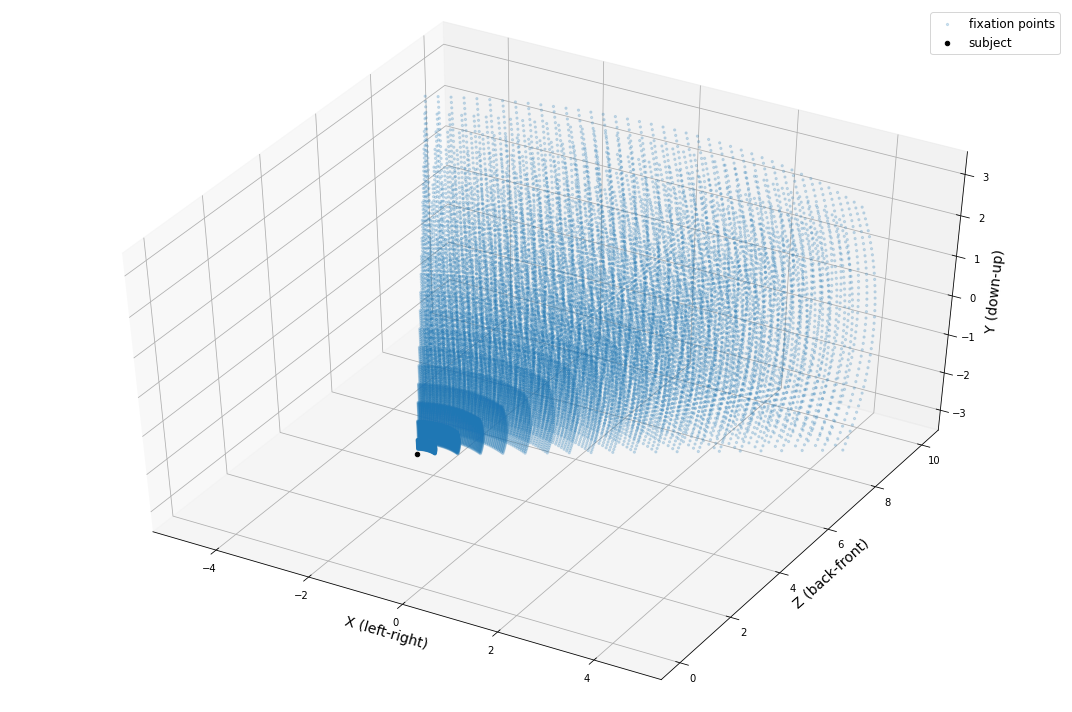

In [47]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset.pos[:, 0], dataset.pos[:, 2], dataset.pos[:, 1], s=5, alpha=0.2, label='fixation points')
ax.scatter(0, 0, 0, s=20, c='k', label='subject')
# ax.set_xlim(-6, 6)
# ax.set_ylim(0, 12)
# ax.set_zlim(-3, 3)
ax.set_xlabel('X (left-right)', fontsize=14)
ax.set_ylabel('Z (back-front)', fontsize=14)
ax.set_zlabel('Y (down-up)', fontsize=14)
ax.view_init(45, -60)
ax.legend(fontsize=12)
# plt.savefig(os.path.join(path_outputs, '3d_dist.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

In [18]:
tmp = target[0:2, :]
print(tmp)

[[-28.          20.20333      0.40000004   1.        ]
 [-26.5641      19.964476     0.4          1.        ]]


In [19]:
tmp.shape

(2, 4)

In [20]:
polar = tmp
cart = polar.copy()
polar_tan = np.tan(np.deg2rad(polar))
print(polar_tan)

[[-0.53170943  0.36799434  0.00698143  0.01745507]
 [-0.49997926  0.36326823  0.00698143  0.01745507]]


In [26]:
back = (np.logical_or(polar[:, 0]>-90, polar[:, 0]<90)-0.5)*2
print(back)

[1. 1.]


In [25]:
np.logical_or(polar[:, 0]<-90, polar[:, 0]>90)

array([False, False])

In [14]:
target

array([[-28.        ,  20.20333   ,   0.40000004,   1.        ],
       [-26.5641    ,  19.964476  ,   0.4       ,   1.        ],
       [-25.128204  ,  19.742281  ,   0.4       ,   1.        ],
       ...,
       [-25.128204  ,  19.742281  ,  10.        ,   1.        ],
       [-26.564098  ,  19.964474  ,  10.        ,   1.        ],
       [-28.        ,  20.203331  ,  10.        ,   1.        ]],
      dtype=float32)

In [28]:
polar2cart(target)

array([[-0.1785976 ,  0.12360681,  0.33589324,  1.        ],
       [-0.17012452,  0.12360679,  0.34026316,  1.        ],
       [-0.1615446 ,  0.12360681,  0.34441936,  1.        ],
       ...,
       [-4.038615  ,  3.0901701 ,  8.610484  ,  1.        ],
       [-4.253113  ,  3.0901697 ,  8.506579  ,  1.        ],
       [-4.4649396 ,  3.0901701 ,  8.39733   ,  1.        ]],
      dtype=float32)

In [12]:
dataset.pos

array([[-0.17859761,  0.12360682,  0.33589324,  1.        ],
       [-0.17012452,  0.1236068 ,  0.34026313,  1.        ],
       [-0.16154462,  0.12360682,  0.34441936,  1.        ],
       ...,
       [-4.0386157 ,  3.0901704 ,  8.610484  ,  1.        ],
       [-4.253113  ,  3.09017   ,  8.506578  ,  1.        ],
       [-4.46494   ,  3.0901704 ,  8.39733   ,  1.        ]],
      dtype=float32)

In [13]:
dataset.pos_polar

array([[-28.        ,  20.20333   ,   0.40000004,   1.        ],
       [-26.5641    ,  19.964476  ,   0.4       ,   1.        ],
       [-25.128204  ,  19.742281  ,   0.4       ,   1.        ],
       ...,
       [-25.128204  ,  19.742281  ,  10.        ,   1.        ],
       [-26.564098  ,  19.964474  ,  10.        ,   1.        ],
       [-28.        ,  20.203331  ,  10.        ,   1.        ]],
      dtype=float32)

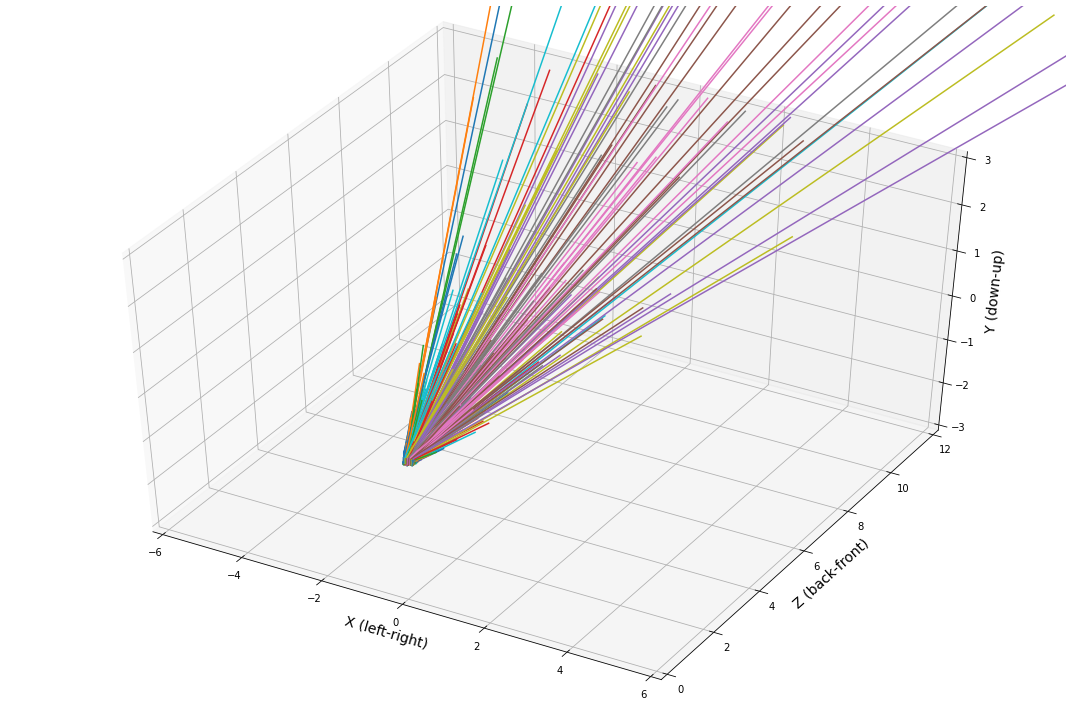

In [31]:
n_sample = 1000
pairs = np.dstack((dataset.polar2cart(target)[::4, :], dataset.polar2cart(ref)[::4, :]))

fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for k in range(n_sample):
    ax.plot(pairs[k, 0, :], pairs[k, 2, :], pairs[k, 1, :])
ax.set_xlim(-6, 6)
ax.set_ylim(0, 12)
ax.set_zlim(-3, 3)
ax.set_xlabel('X (left-right)', fontsize=14)
ax.set_ylabel('Z (back-front)', fontsize=14)
ax.set_zlabel('Y (down-up)', fontsize=14)
ax.view_init(45, -60)
#ax.legend(fontsize=12)
# plt.savefig(os.path.join(path_outputs, '3d_errors.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

In [ ]:
n_image = len(dataset)
brightness = np.zeros((n_image,))
contrast = np.zeros((n_image,))
for k in range(n_image):
#     if (k+1)%1000==0:
#         print(k+1)
    image = dataset[k][0].numpy().squeeze()
    brightness[k] = image.mean()
    contrast[k] = image.std()


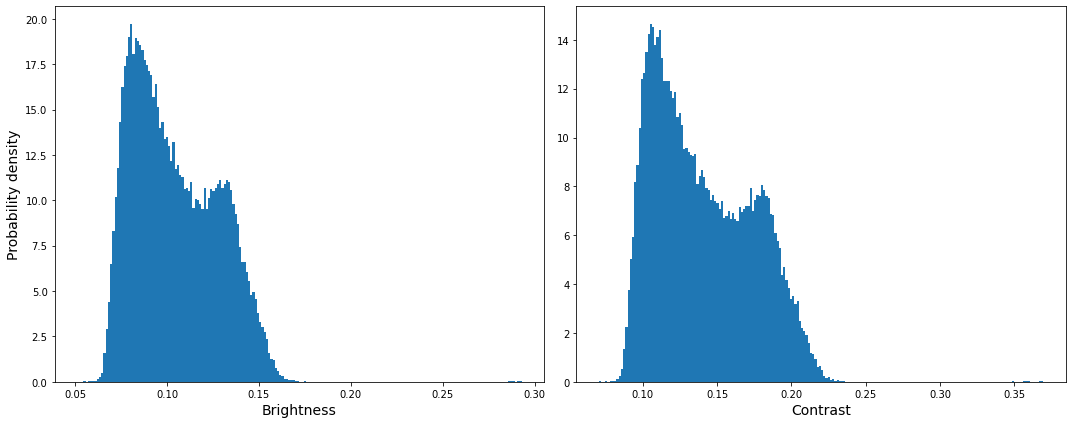

In [158]:
n_bin = 200
fig = plt.figure(figsize=(15, 6), tight_layout=True)
plt.subplot(121)
plt.hist(brightness, n_bin, density=True)
plt.ylabel('Probability density', fontsize=14)
plt.xlabel('Brightness', fontsize=14)
plt.subplot(122)
plt.hist(contrast, n_bin, density=True)
plt.xlabel('Contrast', fontsize=14)
plt.savefig(os.path.join(path_outputs, 'image_stats.png'), pad_inches=0, bbox_inches='tight')
plt.show()